<a href="https://colab.research.google.com/github/nealsonli/sscs-ose-code-a-chip.github.io/blob/cordic_openlane/Notebooks/cordic_openlane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coordinate Rotation Digital Computer (CORDIC) with OpenLane

```
Copyright 2022 Integrated Circuits & Systems Research Lab @ Georgia Institute of Technology
SPDX-License-Identifier: Apache-2.0
```



|Name|Affiliation| Email |IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|:----------:|
|Nealson Li (Lead)|Georgia Institute of Technology|nealson@gatech.edu|Yes|Yes|
|Muya Chang|NVIDIA|muyac@nvidia.com|Yes|Yes|




This notebook introduces CORDIC - Coordinate Rotation Digital Computer, explains the implementation with configurability and generates a tapeout-ready(GDS) design with opensource tools and PDK. CORDIC is an iterative algorithm that calculates sine, cosine, etc. Due to its hardware-friendly algorithm, CORDIC is widely used in designs that have limited area for multipliers. To accelerate the design process and build upon others foundation, it is important that such functional block is available to the hardware open-source community in a reusable, reproducible, and technology independent fashion. This notebook does exactly that and implements configurable CORDIC in Verilog with open-source flow. We encourage the community to reuse this easy plug-and-play CORDIC to develop more hardware designs and open-source resources.

## Introduction
---

In this notebook, you will learn what [CORDIC](https://en.wikipedia.org/wiki/CORDIC) is and how to implement a configurable CORDIC design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) RTL to GDS flow targeting the open-source [SKY130 PDK](https://github.com/google/skywater-pdk/). Specifically the following things:


*   What is CORDIC, How does it work, and What's special about it?
*   How to run RTL simulation and How does the result look like?
*   How to run end-to-end implementation to generate GDS?
*   How does the layout and matrics look like?

Another main purpose of this notebook is to provide a good starting point if in the future you want to design something else, simply replace the verilog/testbench files and everything should be good to go.




## CORDIC
---

### What is Coordinate Rotation Digital Computer (CORDIC)?

CORDIC stands for **CO**ordinate **R**otation **DI**gital **C**omputer. It is a shift-and-add algorithm that can calculate trigonometric functions, hyperbolic functions, square roots and more. Due to its simplicity and efficiency, CORDIC was used in the navigation system of the Apollo program's Lunar Roving Vehicle, processors such as Intel 8087, and FPGAs.

#### Algorithm

Given a vector $(x_{in}, y_{in})$ and a target rotation angle $z_{in}$. A perfect rotation can be described in matrix form as 

$$\begin{bmatrix} x_{out} \\ y_{out}\end{bmatrix} = \begin{bmatrix} cos(z_{in}) & -sin(z_{in}) \\ sin(z_{in}) & cos(z_{in}) \end{bmatrix}\begin{bmatrix} x_{in} \\ y_{in}\end{bmatrix}$$

the same rotation can be decomposed into:
 
$$\begin{bmatrix} x_{out} \\ y_{out}\end{bmatrix} = \begin{bmatrix} cos(α_n) & -sin(α_n) \\ sin(α_n) & cos(α_n) \end{bmatrix} ... \begin{bmatrix} cos(α_0) & -sin(α_0) \\ sin(α_0) & cos(α_0) \end{bmatrix}\begin{bmatrix} x_{in} \\ y_{in}\end{bmatrix}$$

with

 $$\sum_{i=0}^{n} α_i \approx z_{in}$$

CORDIC performs the decomposed rotation with $n$ iterations:

$$\begin{bmatrix} x_{i+1} \\ y_{i+1}\end{bmatrix} = \begin{bmatrix} cos(α_i) & -sin(α_i) \\ sin(α_i) & cos(α_i) \end{bmatrix} \begin{bmatrix} x_{i} \\ y_{i}\end{bmatrix}$$

$$ z_{i+1} = z_{i} - σ_i α_i$$

where

$$\begin{bmatrix} x_{0} \\ y_{0}\end{bmatrix} = \begin{bmatrix} x_{in} \\ y_{in}\end{bmatrix}$$

$$ z_{0} = z_{in}$$

and

$$\begin{bmatrix} x_{out} \\ y_{out}\end{bmatrix} = \begin{bmatrix} x_{n} \\ y_{n}\end{bmatrix}$$

$$ z_{out} = z_{in} - \sum_{i=0}^{n} α_i \approx 0$$

The rotation matrix of iteration $i$ can be written in this scale and rotate form:

$$\begin{bmatrix} cos(α_i) & -sin(α_i) \\ sin(α_i) & cos(α_i) \end{bmatrix} = cos(α_i) \begin{bmatrix} 1 & -tan(α_i) \\  1 & tan(α_i) \end{bmatrix}$$

We choose the elementary angles $α_i$ carefully as

$$α_i = σ_i tan^{-1}(2^{-i})$$ 

where 

$$ σ_i = sign(z_{i}) ∈ \{-1, 1\} $$

Then the rotation matrix of iteration $i$ becomes

$$ (1+2^{-2i})^{1/2} \begin{bmatrix} 1 & -σ_i(2^{-i}) \\  1 & σ_i(2^{-i}) \end{bmatrix}$$ 

This form is hardware friendly since $2^{-i}$ multiplication can be performed with a bit shift operation. Additionally, instead of multiplying the scaling factor every iteration, the scaling can all be performed together after the last iteration. Each iteration now becomes a shift and add operation. 
 <!-- by multiplying the result with   
$$K = \prod_{i=0}^{n} (1+2^{-2i})^{1/2} $$ -->

Shown in the below figure is CORDIC iteratively rotating the vector $(x_{in}, y_{in})$ to target rotation angle $z_{in}$ with $5$ iterations.

![Rotation](https://github.com/nealsonli/CORDIC-OpenLane/blob/main/imgs/rotation_git.gif?raw=true)

#### Mode and Functionality

There are two modes that the CORDIC operates in, rotation mode and vectoring mode. The example explained in the previous section is the rotation mode CORDIC operation.

*   **rotation** mode: given input set $(x_{in}, y_{in}, z_{in})$, CORDIC rotates the vector $(x_{in}, y_{in})$ by $z_{in}$ radians. The outputs are $(x_{out}, y_{out}, z_{out})$, where $(x_{out}, y_{out})$ is the resulting vector and $z_{out}$ is the remaining angle to reach the target $z_{in}$ rotation.
*   **vectoring** mode: CORDIC rotates the input vector $(x_{in}, y_{in})$ towards $y=0$. The outputs are $(x_{out}, y_{out}, z_{out})$, where $(x_{out}, y_{out})$ is the vector that is close to $y=0$ and $z_{out}$ is the angle between $(x_{in}, y_{in})$ and $(x_{out}, y_{out})$ plus $z_{in}$.

Note that the shift and add operation is the same between the two modes, but setting $σ_i$ is different:

\begin{align}
σ_i = \left\{
\begin{array}{cl}
sign(z_{i}) & \text{in rotation mode} \\
-sign(x_{i}) ⋅ sign(y_{i}) &  \text{in vectoring mode}.
\end{array}
\right.
\end{align}

With these two modes and the three inputs, CORDIC provides these functionalities:

|&nbsp; Mode &nbsp;| &nbsp; $x_{in}$  &nbsp;| &nbsp; $y_{in}$  &nbsp;| &nbsp; $z_{in}$  &nbsp;|&nbsp; &nbsp; &nbsp; &nbsp; Output Function &nbsp; &nbsp; &nbsp; &nbsp;|
|:-------:|:--------:|:--------:|:--------:|:---------------:|
|Rotation | 1        | 0        | θ        | $x_{out}=cos(θ)$ <br /> $y_{out}=sin(θ)$
|Vectoring| 1        | $a$        | $\frac{π}{2}$    | $x_{out}=\sqrt{a^2+1}$ <br /> $z_{out}=cot^{-1}(a)$

### What's Special about CORDIC Hardware?

#### Functional Block

There are three blocks in the CORDIC hardware implementation: Angle Adjust, Iteration and Scale, and they are shown in the figure below. 

* Angle adjust block handles the limitation of the CORDIC algorithm: the maximum rotation angle CORDIC can perform is roughly 
$1.7429$ ($100°$).  

 $$\sum_{i=0}^{∞} α_i = \sum_{i=0}^{∞} tan^{-1}(2^{-i}) ≈ 1.7429 $$ 

 Therefore, even with all positive $σ_i$ or all negative $σ_i$ rotations, CORDIC can cover only $200°$. In order to support full circle range of $z_{in}$, angle adjust block rotates the input vector by $180°$ if $z_{in}$ is out of range. An adjusted vector $(x_{adj}, y_{adj})$ with an adjusted angle $z_{adj}$ that is in the supported range is then passed to the iteration block.

* Depending on how many iterations is configured, the iteration block contains $n$ CORDIC units and performs $n$ rotations. Each unit performs one rotation without scaling. Input $x_i$ and $y_i$ to the unit $i$ are shifted $i$ bits. $σ_i$ is set in the CORDIC unit and then selects whether to add or subtract the shifted $x_i$ and $y_i$ to the input $x_i$ and $y_i$. Elementary angle $α_i$ is pre-calculated and passed into unit $i$ as a constant to subtract $z_{i}$

* The scaling block performs all the scaling of each iteration in one shot. The scaling factor is dependent on the number of iterations. The scaling factor $K_n$ with iteration $n$ multiplying the output vector of iteration block can be expressed as 

 $$\begin{bmatrix} x_{out} \\ y_{out}\end{bmatrix} = K_n\begin{bmatrix} x_{n} \\ y_{n}\end{bmatrix}$$

 where

 $$K_n = \prod_{i=0}^{n} (1+2^{-2i})^{1/2} $$ 

![block_diagram](https://github.com/nealsonli/CORDIC-OpenLane/blob/main/imgs/CORDIC_block_diagram.png?raw=true)

#### Configurability

To promote reusability for the hardware open-source community, configurability is emphasized in this CORDIC implementation. There are three hardware parameters that can be set to generate a variety of CORDIC designs.

* `NUM_ITER` : total number of CORDIC iterations, the higher the better.
* `NUM_STAGE` : number of stages in the hardware in order to meet clock timing.
* `EN_SCALE` : whether the hardware for scaling at the end of CORDIC is included.

Depending on the users' design targets such as precision, timing, power, etc., this implementation can be configured to meet their requirements. Users can simply instantiate the CORDIC module with the desired configuration in their design, verify the overall functionality, and flawlessly run the synthesis and place and route flow at their target technology node.


Note that although the more the iterations the less the output error, $12$ iterations is the sweet spot for performance vs. computation workload, and we would recommend this configuration with a desired stage count.

![bconfig](https://github.com/nealsonli/CORDIC-OpenLane/blob/main/imgs/CORDIC_config.png?raw=true)

## Simulation
---

In [ ]:
#@title Install Dependencies {display-mode: "form"}
#@markdown Click the ▷ button to setup the simulation environment.

#@markdown Main components we will install

#@markdown *   verilator : a free and open-source software tool which converts Verilog (a hardware description language) to a cycle-accurate behavioral model in C++ or SystemC.

!apt-get install verilator
!pip3 install fxpmath

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  gtkwave systemc
The following NEW packages will be installed:
  verilator
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 2,878 kB of archives.
After this operation, 13.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 verilator amd64 3.916-1build1 [2,878 kB]
Fetched 2,878 kB in 1s (4,099 kB/s)
Selecting previously unselected package verilator.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../verilator_3.916-1build1_amd64.deb ...
Unpacking verilator (3.916-1build1) ...
Setting up verilator (3.916-1build1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, htt

In [ ]:
%%capture output_cordic_verilogs

#@title Download CORDIC Verilog Files

#@markdown Click the ▷ button to download the rtl files.
#@markdown We have provided the CORDIC verilog files under "cordic" directory after downloading,
#@markdown the brief explanation of each files is as below:

#@markdown *   cordic/rtl
#@markdown    *   `cordic_config.v` : sets the configuration such as number of iterations and number of stages, etc.
#@markdown    *   `cordic.v` : top level that contains the three main modules: Angle Adjust, Iteration and Scale.
#@markdown    *   `angle_adjust.v` : performs $180°$ flip on $(x_{in}, y_{in})$ and adjust $z_{in}$ if required.
#@markdown    *   `cordic_iteration.v` : instantiates $n$ CORDIC units to performe $n$ iterations with $s$ stages.   
#@markdown    *   `cordic_unit.v` : performs shift and add of one rotation without scaling.
#@markdown    *   `scale.v` : scales the output vetor of iteration block back to its unit circle.
#@markdown *   cordic/bench
#@markdown    *   `tb_cordic.cpp` : top C++ testbench simulation file. 
#@markdown    *   `testcase.h` : file containing input testcase.
#@markdown *   cordic/simulation
#@markdown    *   `result` : file containing result 
#@markdown    *   `waveform.vcd` : waveform VCD file dumpped by Verilator. 


!rm -rf CORDIC-OpenLane
!git clone https://github.com/nealsonli/CORDIC-OpenLane.git
!rm -rf cordic
!mv CORDIC-OpenLane/cordic .
!rm -rf CORDIC-OpenLane

In [ ]:
%%capture output_simulation_config_cordic

#@title Configure CORDIC

#@markdown There are three user-defined parameters that would affect the hardware cost, therefore we expose such configuration files to the users based on the preference.
#@markdown Please fill in the parameters and click the ▷ button to (re-)config your CORDIC

NUM_ITER = 12 #@param {type:"integer"}
NUM_STAGE = 3 #@param {type:"integer"}
EN_SCALE = 1 #@param {type:"integer"}

with open("cordic/rtl/cordic_config.v", "w") as f:
  f.write("`ifndef __CORDIC_CONFIG__\n")
  f.write("`define __CORDIC_CONFIG__\n")
  f.write("\n")
  f.write(f"`define NUM_ITER {NUM_ITER}\n")
  f.write(f"`define NUM_STAGE {NUM_STAGE}\n")
  f.write(f"`define EN_SCALE {EN_SCALE}\n")
  f.write(f"`define TOTAL_WIDTH 49\n")
  f.write("\n")
  f.write("`endif")

!verilator -Wall --trace -cc -I/content/cordic/rtl /content/cordic/rtl/cordic.v --exe /content/cordic/bench/tb_cordic.cpp

Running RTL simulation ... 

  [Wait Cycles] 3 cycles
  [ Input Data] function = 0x0, x = 0x0600, y = 0x0800, z = 0xcdbd
  [Output Data] function = 0x0, x = 0x0801, y = 0xfa01, z = 0xfffc

RTL Simulation finished. 


[Dut Result]
 Input (x, y) = (  3.0000,   4.0000) ... rotating -90.000 degrees
Output (x, y) = (  4.0020,  -2.9980) ... with -0.028 degrees left

Golden (x, y) = (  4.0000,  -3.0000)

To visualize the result more easily, we've made the GIF for you:


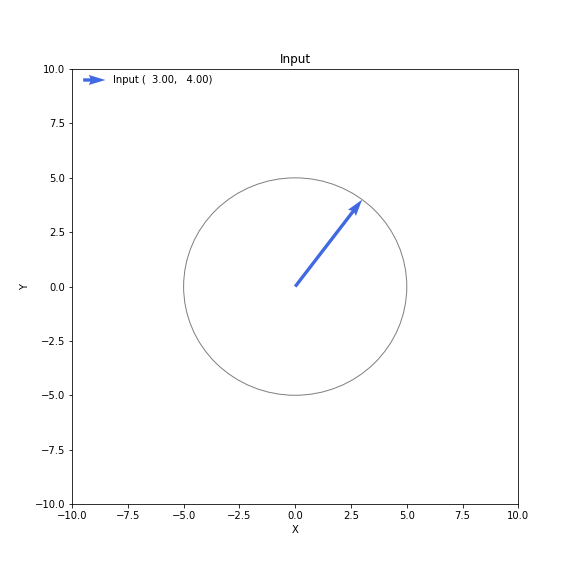

In [ ]:
#@title Running Simulation

#@markdown Please fill in the testcase below and click the ▷ button to (re-)run simulation.

#@markdown Parameter Format & Range:
#@markdown *   $Mode$ : "Rotation" or "Vectoring"
#@markdown *   $x_{in}$ $\in [ -32, 32 )$ Float
#@markdown *   $y_{in}$ $\in [ -32, 32 )$ Float
#@markdown *   $z_{in}$ $\in [ -180°, 180° )$ Float

Mode_Map = {"Rotation": 0, "Vectoring": 1}
Mode = "Rotation" #@param ["Rotation", "Vectoring"]
Xin = 3 #@param {type:"number"}
Yin = 4 #@param {type:"number"}
Zin = -90 #@param {type:"number"}

from fxpmath import Fxp
import math
import numpy as np

# Have some offset for user easibility
OFFSET = pow(2, 4)

# Parse the user defined parameters
Xin_raw = Fxp(Xin/OFFSET       , dtype='S3.13')
Yin_raw = Fxp(Yin/OFFSET       , dtype='S3.13')
Zin_raw = Fxp(math.radians(Zin), dtype='S3.13')

# Write the user defined parameters to the testcase file
with open("cordic/bench/testcase.h", "w") as f:
  f.write(f"int func = {Mode_Map[Mode]};\n");
  f.write(f"int x    = {Xin_raw.hex()};\n");
  f.write(f"int y    = {Yin_raw.hex()};\n");
  f.write(f"int z    = {Zin_raw.hex()};\n");

# Compile and run the simulation
!make -C obj_dir -f Vcordic.mk Vcordic > /dev/null
print("Running RTL simulation ... ")
!obj_dir/Vcordic
print("RTL Simulation finished. \n\n")

def HexToInt(hex):
  sign = 1
  if hex & 0x8000:
    hex = pow(2, 16) - hex
    sign = -1
  hex = hex/pow(2, 13)
  return sign*hex

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

# Parse the result from the simulation
Xout_raw = []
Yout_raw = []
Zout_raw = []
with open("cordic/simulation/result", "r") as f:
  while True:
    temp = f.readline()
    if not temp: break
    Xout_raw.append(int(temp))
    Yout_raw.append(int(f.readline()))
    Zout_raw.append(int(f.readline()))

Xout = [HexToInt(xout_raw)*OFFSET for xout_raw in Xout_raw]
Yout = [HexToInt(yout_raw)*OFFSET for yout_raw in Yout_raw]
Zout = [math.degrees(HexToInt(zout_raw)) for zout_raw in Zout_raw]

# Some useful information
Rin = math.sqrt(Xin*Xin+Yin*Yin)
Rout = math.sqrt(Xout[-1]*Xout[-1]+Yout[-1]*Yout[-1])

# Calculate the golden
if Mode == "Rotation":
  Xgolden, Ygolden = rotate([0, 0], [Xin, Yin], math.radians(Zin))

  print("[Dut Result]")
  print(f" Input (x, y) = ({Xin:8.4f}, {Yin:8.4f}) ... rotating {Zin:.3f} degrees")
  print(f"Output (x, y) = ({Xout[-1]:8.4f}, {Yout[-1]:8.4f}) ... with {Zout[-1]:.3f} degrees left")
  print()
  print(f"Golden (x, y) = ({Xgolden:8.4f}, {Ygolden:8.4f})")
  print()
elif Mode == "Vectoring":
  Xgolden = np.sign(Xin)*Rin
  Ygolden = 0
  Zgolden = math.degrees(math.atan(Yin/Xin)) + Zin
  
  print("[Dut Result]")
  print(f" Input (x, y) = ({Xin:8.4f}, {Yin:8.4f}) ... vectoring with {Zin:.3f} degrees")
  print(f"Output (x, y) = ({Xout[-1]:8.4f}, {Yout[-1]:8.4f}, {Zout[-1]:.3f})")
  print()
  print(f"Golden (x, y) = ({Xgolden:8.4f}, {Ygolden:8.4f}, {Zgolden:.3f})")
  print()

# Make the plots
import matplotlib.pyplot as plt

plotted_images = []
ax = plt.gca()
fig = plt.gcf()

ax.cla() # clear things for fresh plot
fig.set_size_inches(8, 8)

# Plot the circle
radius = max(Rin, Rout)
circle = plt.Circle((0, 0), Rin, color='grey', fill=False)
ax.add_patch(circle)

# Set the axis limits
plt.xlim(-(radius*2), (radius*2))
plt.ylim(-(radius*2), (radius*2))
plt.xlabel("X")
plt.ylabel("Y")

# Plot the input vector
QVIN = plt.quiver(Xin, Yin, color='royalblue', angles='xy', scale=1, scale_units='xy')
plt.quiverkey(QVIN, -(radius*1.7), (radius*1.9), radius*0.2, f"Input ({Xin:6.2f}, {Yin:6.2f})", coordinates='data', labelpos='E')
plt.title(f"Input")
plotted_images.append(f"cordic/simulation/fig_0.png")
plt.savefig(plotted_images[-1])

# Create the animation
QVMIDDLE = []
for i in range(len(Xout)):
  if i == len(Xout)-1:
    QVMIDDLE = plt.quiver(Xout[i], Yout[i], color='limegreen', angles='xy', scale=1, scale_units='xy')
    QVMIDDLE_KEY = plt.quiverkey(QVMIDDLE, -(radius*1.7), (radius*1.8), radius*0.2, f"Output ({Xout[i]:6.2f}, {Yout[i]:6.2f})", coordinates='data', labelpos='E')
  else:
    QVMIDDLE = plt.quiver(Xout[i], Yout[i], color='lightskyblue', angles='xy', scale=1, scale_units='xy')
    QVMIDDLE_KEY = plt.quiverkey(QVMIDDLE, -(radius*1.7), (radius*1.8), radius*0.2, f"Output ({Xout[i]:6.2f}, {Yout[i]:6.2f})", coordinates='data', labelpos='E')
  plotted_images.append(f"cordic/simulation/fig_{i+1}.png")
  if i == len(Xout)-1:
    plt.title(f"After scaled")
  else:
    plt.title(f"After {i+1} stages")
  plt.savefig(plotted_images[-1])
  QVMIDDLE.remove()
  QVMIDDLE_KEY.remove()

# Plot the golden vector
QVGOLDEN = plt.quiver(Xgolden, Ygolden, color='darkkhaki', angles='xy', scale=1, scale_units='xy')
plt.quiverkey(QVGOLDEN, -(radius*1.7), (radius*1.8), radius*0.2, f"Golden ({Xgolden:6.2f}, {Ygolden:6.2f})", coordinates='data', labelpos='E')
plotted_images.append(f"cordic/simulation/fig_{len(Xout)+1}.png")
plt.title(f"Golden Output")
plt.savefig(plotted_images[-1])

# Cloase the figure since we want to display the gif
plt.close(fig)

# Make the GIF
import imageio
images = []
for image in plotted_images:
    images.append(imageio.imread(image))
imageio.mimsave("cordic/simulation/animation.gif", images, duration=1)

# Display the GIF
from IPython.display import Image
print("To visualize the result more easily, we've made the GIF for you:")
Image(filename="cordic/simulation/animation.gif")



## Implementation


In [ ]:
#@title Install Dependencies {display-mode: "form"}
#@markdown Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

#@markdown Main components we will install

#@markdown *   Open_pdks.sky130a : a PDK installer for open-source EDA tools.
#@markdown *   Openlane : an automated RTL to GDSII flow based on several components including OpenROAD, Yosys, Magic, Netgen, CVC, SPEF-Extractor, KLayout and a number of custom scripts for design exploration and optimization.
#@markdown *   GDSTK : a C++ library for creation and manipulation of GDSII and OASIS files. 

import os
import pathlib
import sys

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))

CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')

%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}

!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned

!bin/micromamba install --quiet \
                        --yes \
                        --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        openlane

!bin/micromamba install --quiet \
                        --yes \
                        --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        gdstk

bin/micromamba
env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
env: LD_LIBRARY_PATH=/content/conda-env/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env
  Package                             Version  Build                 Channel                 Size
───────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
───────────────────────────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex           

### Write OpenLane Flow Configuration

We target 50MHz clock frequency and 400um x 400um layout in this tutorial but it can be easily changed based on the requirement.

For more information, please refer to [Documentation](https://openlane.readthedocs.io/en/latest/reference/configuration.html).

In [ ]:
%%writefile config.json
{
    "DESIGN_NAME": "cordic",
    "VERILOG_FILES": "dir::cordic/rtl/*.v",
    "CLOCK_PERIOD": 20,
    "CLOCK_NET": "i_clk",
    "CLOCK_PORT": "i_clk",

    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 400 400"
}

Writing config.json


### Run OpenLane Flow

[OpenLane](https://openlane.readthedocs.io/en/latest/) is an automated [RTL](https://en.wikipedia.org/wiki/Register-transfer_level) to [GDSII](https://en.wikipedia.org/wiki/GDSII) flow based on several components including [OpenROAD](https://theopenroadproject.org/), [Yosys](https://yosyshq.net/yosys/), [Magic](http://www.opencircuitdesign.com/magic/), [Netgen](http://opencircuitdesign.com/netgen/) and custom methodology scripts for design exploration and optimization targeting [open source PDKs](https://github.com/google/open-source-pdks). We run this flow to generate the GDS file of the configured CORDIC.

![img](https://openlane.readthedocs.io/en/latest/_images/flow_v1.png)

In [ ]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2022.11.12_3_g1298859-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: not enough values to unpack (expected 3, got 1)
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a519523b0d9bc913a6f87a5eed083597ed9e2e93, tested: 0059588eebfc704681dc2368bd1d33d96281d10f)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
The version of magic used in building the PDK does not match the version OpenLane was tested on (installed: f0668447616c071f145d3d3fa1dfde9762b62b7b, tested: 94daf986ab9aa94a9ae2ac3539fa5def9bd2a1ac)
This may introduce some issues. You may want to re-install the PDK by invoking `make pdk`.
[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]:

### Display Layout

Because the layout SVG file is quite large so we don't recommend displaying it directly in the notebook, instead it will be exported as "cordic.svg" under the home directory.
A sample layout we got from previous runs is shown to give a brief idea of how the layout looks like.

In [ ]:
import pathlib
import gdstk

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('cordic.svg')

![bconfig](https://github.com/nealsonli/CORDIC-OpenLane/blob/main/imgs/cordic.png?raw=true)

### Metrics

This sections prints out some status of the OpenLane run.

For more information, please refer to [Documentation](https://openlane.readthedocs.io/en/latest/reference/datapoint_definitions.html).


In [ ]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
final_summary_reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(final_summary_reports[-1])
df.transpose()

,0
design,/content
design_name,cordic
config,RUN_2022.11.21_08.21.35
flow_status,flow completed
total_runtime,0h7m16s0ms
routed_runtime,0h5m25s0ms
(Cell/mm^2)/Core_Util,74575.0
DIEAREA_mm^2,0.16
CellPer_mm^2,37287.5
OpenDP_Util,41.31
